# Oja's rule

Oja's rule is a Hebbian learning rule, in which synapse weight is determined by pre-synaptic and post-synaptic neurons' firing rate.

$$ \frac{d w_{ij}}{dt} = \gamma(\upsilon_i \upsilon_j - w_{ij}\upsilon_i ^ 2)$$

In [1]:
import brainpy as bp
import brainpy.numpy as np
import matplotlib.pyplot as plt
import bpmodels

In [2]:
# define a fake firing rate neuron for test
def get_fr_neu():
    ST = bp.types.NeuState({'r': 0, 'nothing': 0.})
    
    def update(ST, _t_):
        ST['nothing'] = 0.
        
    return bp.NeuType(name='fr_zombie_neuron',
                 requires=dict(ST=ST),
                 steps=update,
                 mode='scalar')

# set params
pre_neu_num = 2
post_neu_num = 1
bp.profile.set(backend="numba", dt=0.02, merge_steps=True, show_code=False)

In [3]:
# build network
fr_neu = get_fr_neu()
oja_synapse = bpmodels.learning_rules.get_Oja()
pre_neu = bp.NeuGroup(fr_neu,
                      geometry=(pre_neu_num, ),
                      monitors=['r'])
post_neu = bp.NeuGroup(fr_neu,
                       geometry=(post_neu_num, ),
                       monitors=['r'])
pre_neu.ST['r'] = 1.
post_neu.ST['r'] = 1.

syn = bp.SynConn(oja_synapse,
                 pre_group=pre_neu,
                 post_group=post_neu,
                 conn=bp.connect.All2All(),
                 monitors=['w']
                 )

net = bp.Network(pre_neu, syn, post_neu)

# create input
current_mat_in = []
current_mat_out = []
current1, _ = bp.inputs.constant_current([(2., 20.), (0., 20.)] * 3 + [(0., 20.), (0., 20.)] * 2)
current2, _ = bp.inputs.constant_current([(0., 20.), (2., 20.)] * 5)
current3, _ = bp.inputs.constant_current([(2., 20.), (0., 20.)] * 5)
current_mat_in = np.vstack((current1, current2))
#current_mat_out = np.vstack((current3, current3))
current_mat_out = current3

# simulate network
net.run(duration=200., 
        inputs=[(pre_neu, 'ST.r', current_mat_in.T, '='), 
                (syn, 'post.r', current_mat_out.T, '=')
                ],
        report=False)

With Oja's rule, we can see that synapse weight increases when pre-synaptic and post-synaptic neurons fire together. Otherwise, synapse weight descreases.

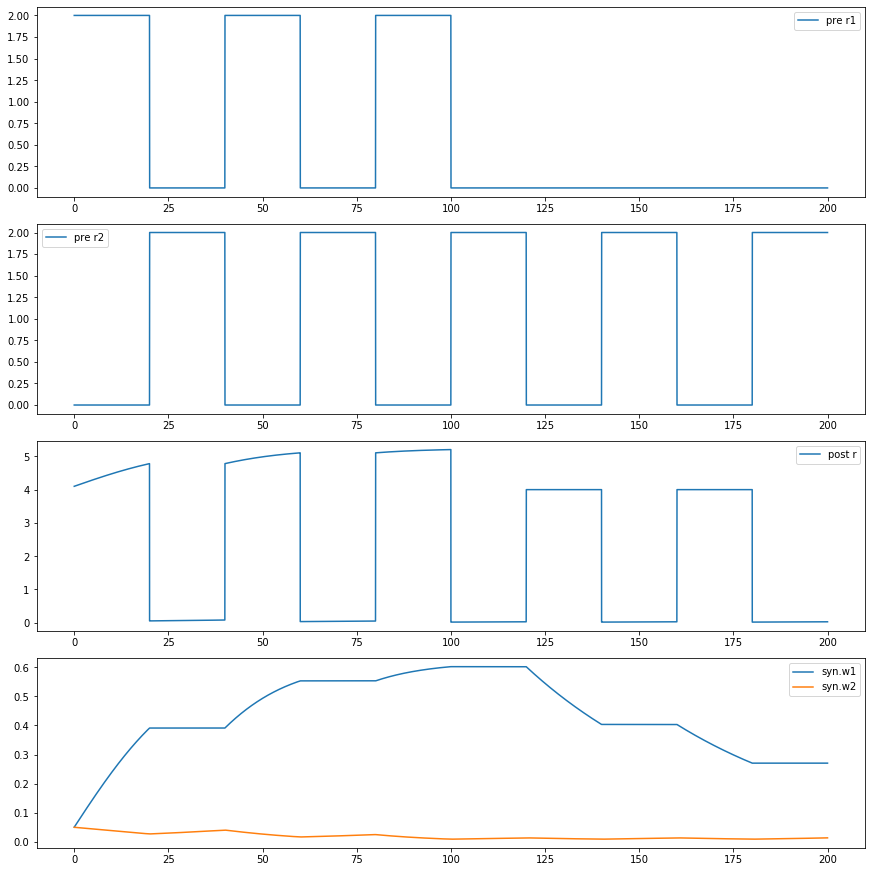

In [4]:
# paint
fig, gs = bp.visualize.get_figure(4, 1, 3, 12)

fig.add_subplot(gs[0, 0])
plt.plot(net.ts, pre_neu.mon.r[:, 0], label='pre r1')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(net.ts, pre_neu.mon.r[:, 1], label='pre r2')
plt.legend()

fig.add_subplot(gs[2, 0])
plt.plot(net.ts, post_neu.mon.r[:, 0], label='post r')
plt.legend()

fig.add_subplot(gs[3, 0])
plt.plot(net.ts, syn.mon.w[:, 0], label='syn.w1')
plt.plot(net.ts, syn.mon.w[:, 1], label='syn.w2')
plt.legend()
plt.show()